# Risk parity (equal risk contribution) portfolio selection

### Import libraries

In [1]:
import ipopt
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
%matplotlib inline

In [2]:
np.random.seed(492305)

### Generate random data for 10 stocks

In [3]:
# Random data for 10 stocks
n = 10
Q = np.random.random((n,n))
Q = np.dot(Q,Q.T)/1000
# Q
mu = np.random.rand(n) / 100
# mu

### Compute equal risk contribution (ERC) portfolio

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{w} & \displaystyle \sum_{i=1}^n \sum_{j=1}^n \left( w_i (Qw)_i - w_j (Qw)_j \right)^2 \\
  \mbox{s.t.} & \sum_{i=1}^n w_i = 1 \\
  & w \geq 0
 \end{array}
\end{equation}

Weights of "1/n" portfolio.

In [4]:
w0 = [1.0/n] * n
w0

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Define objective function, constraints, gradient of objective fucntion, and jacobian of constrants for the ERC problem.

In [5]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(n)
        # Insert your gradient computations here
        # You can use finite differences to check the gradient
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * n])

    def intermediate(
            self,
            alg_mod,
            iter_count,
            obj_value,
            inf_pr,
            inf_du,
            mu,
            d_norm,
            regularization_size,
            alpha_du,
            alpha_pr,
            ls_trials
            ):

        # Example for the use of the intermediate callback.
        print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))

Define objective function, constraints, gradient of objective fucntion, and jacobian of constrants for the ERC problem.

In [6]:
# Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization

lb = [0.0] * n  # lower bounds on variables
ub = [1.0] * n  # upper bounds on variables
cl = [1]        # lower bounds on constraints
cu = [1]        # upper bounds on constraints

# Define IPOPT problem
nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
# Set the IPOPT options
nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
nlp.addOption('tol'.encode('utf-8'), 1e-10)

# Solve the problem
w_erc, info = nlp.solve(w0)

print("\nOptimal solution: w = %s\n" % repr(w_erc))
print("Objective function value = %s\n" % repr(info['obj_val']))

Objective value at iteration #0 is - 1.31905e-06
Objective value at iteration #1 is - 1.31896e-06
Objective value at iteration #2 is - 1.31402e-06
Objective value at iteration #3 is - 1.31153e-06
Objective value at iteration #4 is - 1.26866e-06
Objective value at iteration #5 is - 1.6072e-07
Objective value at iteration #6 is - 1.2478e-08
Objective value at iteration #7 is - 8.3951e-10
Objective value at iteration #8 is - 5.01946e-10
Objective value at iteration #9 is - 1.45533e-11
Objective value at iteration #10 is - 3.1123e-12
Objective value at iteration #11 is - 5.44062e-14
Objective value at iteration #12 is - 6.73984e-15
Objective value at iteration #13 is - 2.24587e-15
Objective value at iteration #14 is - 2.7721e-17

Optimal solution: w = array([0.06627952, 0.07349027, 0.11936646, 0.15390808, 0.08789186,
       0.08429809, 0.08256351, 0.1349641 , 0.11164464, 0.08559347])

Objective function value = 2.7721041386964047e-17



In [7]:
# Check constraint sum(w) = 1
np.allclose(np.sum(w_erc),1)

True

Compute variance and asset risk contributions for the ERC portfolio.

In [8]:
# Compute variance and asset risk contributions for the ERC portfolio
var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
std_ERC = np.sqrt(var_ERC)
RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC

In [9]:
#np.set_printoptions(formatter={'float': '{: 0.5f}'.format}):
#print("Risk contributions of assets in the ERC portfolio:\n{0}".format(RC_ERC))   
with np.printoptions(precision=6, suppress=True):
    print("Risk contributions of assets in the ERC portfolio:\n{0}".format(RC_ERC))

Risk contributions of assets in the ERC portfolio:
[0.005315 0.005315 0.005315 0.005315 0.005315 0.005315 0.005315 0.005315
 0.005315 0.005315]


In [10]:
# Check that sum of risk contributions is equal to portfolio standard deviation
np.allclose(np.sum(RC_ERC), std_ERC)

True

### Compute minimum variance portfolio

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & w^TQw \\
{\rm s.t.} & \sum_i w_i = 1\\
& w \geq 0
\end{array}
\end{equation}

In [11]:
w1 = cp.Variable(n)
prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)),
                 [sum(w1) == 1,
                  w1 >= 0])
prob1.solve(solver=cp.CPLEX, verbose=True,cplex_params={"qpmethod": 6})

# Print results
print("\nSolution status: ", prob1.status)
print("Solution optimal value: ", prob1.value)
print("Solution w: ")
print(w1.value)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 45
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 10
  Integer space required    = 10
  Total non-zeros in factor = 55
  Total FP ops to factor    = 385
Tried aggregator 1 time.
QP Presolve eliminated 10 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 45
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 10
  Integer space required    = 10
  Total

In [12]:
# Check constraint sum(w) = 1
np.allclose(np.sum(w1.value),1)

True

In [13]:
w_minVar = w1.value
var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
ret_minVar = np.dot(mu, w_minVar)
print("Minimum variance portfolio:\n")
print("   Solution status =", prob1.status)
print("    Solution value =", prob1.value)
print("          Variance =", var_minVar)
print("   Expected return =", ret_minVar)
print("Standard deviation =", np.sqrt(var_minVar))

Minimum variance portfolio:

   Solution status = optimal
    Solution value = 0.0014925004316582186
          Variance = 0.0014925004316582186
   Expected return = 0.0008253599967005114
Standard deviation = 0.038632893130831125


### Compare three portfolios - ERC, minimum variance and equally-weighted

In [14]:
# ERC portfolio return
ret_ERC = np.dot(mu, w_erc)

# 1/n portfolio return
ret_init = np.dot(mu, w0)
# 1/n portfolio variance
var_init = np.dot(w0, np.dot(Q, w0))

In [15]:
# Risk Contributions (RC) of each portfolio assets
std_minVar = np.sqrt(var_minVar)
std_init = np.sqrt(var_init)
RC_minVar = (w_minVar * np.dot(Q, w_minVar)) / std_minVar
RC_init = (w0 * np.dot(Q, w0)) / std_init
#RC_ERC

In [16]:
print('       Portfolio ERC return = {0:9.5f}'.format(ret_ERC))
print('    Portfolio minVar return = {0:9.5f}'.format(ret_minVar))
print('       Portfolio 1/n return = {0:9.5f}'.format(ret_init))
print('      Portfolio ERC st.dev. = {0:9.5f}'.format(std_ERC))
print('   Portfolio minVar st.dev. = {0:9.5f}'.format(std_minVar))
print('      Portfolio 1/n st.dev. = {0:9.5f}'.format(std_init))

       Portfolio ERC return =   0.00511
    Portfolio minVar return =   0.00083
       Portfolio 1/n return =   0.00553
      Portfolio ERC st.dev. =   0.05315
   Portfolio minVar st.dev. =   0.03863
      Portfolio 1/n st.dev. =   0.05689


In [17]:
w_list = [w_erc, w_minVar, w0] 
# using zip() to print list vertically
print('Portfolio weights for ERC, minVar and 1/n portfolios:')
for w1, w2, w3 in zip(*w_list):
    print('                {0:0.7f}   {1:0.7f}   {2:0.7f}'.format(w1, w2, w3))

RC_list = [RC_ERC, RC_minVar, RC_init] 
# using zip() to print list vertically
print('\nAsset risk contributions for ERC, minVar and 1/n portfolios:')
for RC1, RC2, RC3 in zip(*RC_list):
    print('                {0:0.7f}   {1:0.7f}   {2:0.7f}'.format(RC1, RC2, RC3))

print('\nSum of asset risk contributions for ERC, minVar and 1/n portfolios:')
print('                {0:0.7f}   {1:0.7f}   {2:0.7f}'.format(sum(RC_ERC), sum(RC_minVar), sum(RC_init)))

print('\nStandard deviation for ERC, minVar and 1/n portfolios:')
print('                {0:0.7f}   {1:0.7f}   {2:0.7f}'.format(std_ERC, std_minVar, std_init))

Portfolio weights for ERC, minVar and 1/n portfolios:
                0.0662795   0.0000000   0.1000000
                0.0734903   0.0000000   0.1000000
                0.1193665   0.0000000   0.1000000
                0.1539081   0.6651318   0.1000000
                0.0878919   0.0000000   0.1000000
                0.0842981   0.0000000   0.1000000
                0.0825635   0.0000000   0.1000000
                0.1349641   0.3348682   0.1000000
                0.1116446   0.0000000   0.1000000
                0.0855935   0.0000000   0.1000000

Asset risk contributions for ERC, minVar and 1/n portfolios:
                0.0053149   0.0000000   0.0080514
                0.0053149   0.0000000   0.0072693
                0.0053149   0.0000000   0.0044303
                0.0053149   0.0256960   0.0033853
                0.0053149   0.0000000   0.0060754
                0.0053149   0.0000000   0.0063576
                0.0053149   0.0000000   0.0064459
                0.0053149   0.0129

Plot results.

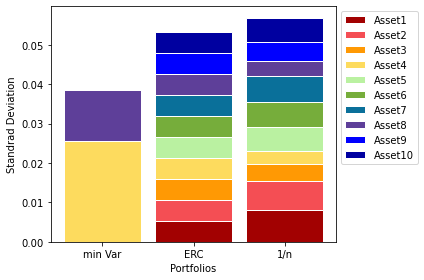

In [18]:
# Data
r = [0,1,2]
raw_data = {'Asset1': [RC_minVar[0], RC_ERC[0], RC_init[0]], \
        'Asset2': [RC_minVar[1], RC_ERC[1], RC_init[1]], \
        'Asset3': [RC_minVar[2], RC_ERC[2], RC_init[2]], \
        'Asset4': [RC_minVar[3], RC_ERC[3], RC_init[3]], \
        'Asset5': [RC_minVar[4], RC_ERC[4], RC_init[4]], \
        'Asset6': [RC_minVar[5], RC_ERC[5], RC_init[5]], \
        'Asset7': [RC_minVar[6], RC_ERC[6], RC_init[6]], \
        'Asset8': [RC_minVar[7], RC_ERC[7], RC_init[7]], \
        'Asset9': [RC_minVar[8], RC_ERC[8], RC_init[8]], \
        'Asset10': [RC_minVar[9], RC_ERC[9], RC_init[9]]}
df = pd.DataFrame(raw_data)

totals = [i+j+k+l+m+n+o+p+r+s for i,j,k,l,m,n,o,p,r,s in zip(df['Asset1'], 
df['Asset2'], df['Asset3'], df['Asset4'], df['Asset5'], df['Asset6'], df['Asset7'], 
df['Asset8'], df['Asset9'], df['Asset10'])]
Asset1 = [i  for i,j in zip(df['Asset1'], totals)]
Asset2 = [i for i,j in zip(df['Asset2'], totals)]
Asset3 = [i for i,j in zip(df['Asset3'], totals)]
Asset4 = [i for i,j in zip(df['Asset4'], totals)]
Asset5 = [i for i,j in zip(df['Asset5'], totals)]
Asset6 = [i for i,j in zip(df['Asset6'], totals)]
Asset7 = [i for i,j in zip(df['Asset7'], totals)]
Asset8 = [i for i,j in zip(df['Asset8'], totals)]
Asset9 = [i for i,j in zip(df['Asset9'], totals)]
Asset10 = [i for i,j in zip(df['Asset10'], totals)]

fig = plt.figure()

# plot
barWidth = 0.85
names = ('min Var','ERC','1/n')
# Create Asset1 Bars
plt.bar(r, Asset1, color='#A20101', edgecolor='white', width=barWidth, 
label="Asset1")
# Create Asset2 Bars
plt.bar(r, Asset2, bottom=Asset1, color='#F44E54', edgecolor='white', 
width=barWidth, label="Asset2")
# Create Asset3 Bars
plt.bar(r, Asset3, bottom=[i+j for i,j in zip(Asset1, Asset2)], color='#FF9904', 
edgecolor='white', width=barWidth, label="Asset3")
# Create Asset4 Bars
plt.bar(r, Asset4, bottom=[i+j+k for i,j,k in zip(Asset1, Asset2, Asset3)], 
color='#FDDB5E', edgecolor='white', width=barWidth, label="Asset4")
# Create Asset5 Bars
plt.bar(r, Asset5, bottom=[i+j+k+l for i,j,k,l in zip(Asset1, Asset2, Asset3, 
Asset4)], color='#BAF1A1', edgecolor='white', width=barWidth, label="Asset5")
# Create Asset6 Bars
plt.bar(r, Asset6, bottom=[i+j+k+l+m for i,j,k,l,m in zip(Asset1, Asset2, 
Asset3, Asset4, Asset5)], color='#76AD3B', edgecolor='white', width=barWidth, 
label="Asset6")
# Create Asset7 Bars
plt.bar(r, Asset7, bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(Asset1, Asset2, 
Asset3, Asset4, Asset5, Asset6)], color='#0A709A', edgecolor='white', 
width=barWidth, label="Asset7")
# Create Asset8 Bars
plt.bar(r, Asset8, bottom=[i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(Asset1,  
Asset2, Asset3, Asset4, Asset5, Asset6, Asset7)], color='#5E3F99', 
edgecolor='white', width=barWidth, label="Asset8")
# Create Asset9 Bars
plt.bar(r, Asset9, bottom=[i+j+k+l+m+n+o+p for i,j,k,l,m,n,o,p in zip(Asset1,  
Asset2, Asset3, Asset4, Asset5, Asset6, Asset7, Asset8)], color='#0000FF', 
edgecolor='white', width=barWidth, label="Asset9")
# Create Asset10 Bars
plt.bar(r, Asset10, bottom=[i+j+k+l+m+n+o+p+r for i,j,k,l,m,n,o,p,r in zip(Asset1,  
Asset2, Asset3, Asset4, Asset5, Asset6, Asset7, Asset8, Asset9)], color='#0000A0', 
edgecolor='white', width=barWidth, label="Asset10")

# Custom x axis
plt.xticks(r, names)
plt.xlabel("Portfolios")

# Custom y axis
plt.ylabel("Standrad Deviation")

# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Save figure as image
plt.tight_layout()
plt.savefig('ERC.png', dpi=300)
plt.savefig('ERC.pdf')

# Show graphics
plt.show()

In [19]:
# Close figure
plt.close(fig)